In [1]:
from project_paths import *

import pandas as pd
import numpy as np
import math
import matplotlib
from matplotlib import pylab as plt

#### We analyze how the target variable is related to each feature variable

In [2]:
# Loading lists of continuous and categorical features 
categorical_features = load_list_from_pkl('categorical_features.pkl')
continuous_features = load_list_from_pkl('continuous_features.pkl')

# Loading the data
# read the data
df = pd.read_csv(working_data_csv)
print("Row count:", df.shape[0], "Column count:", df.shape[1])

Row count: 39644 Column count: 61


### A bit of preprocessing here
#### We have the following features in the data:
Set 1:
 - data_channel_is_lifestyle	Is data channel 'Lifestyle'?
 - data_channel_is_entertainment	Is data channel 'Entertainment'?
 - data_channel_is_bus	Is data channel 'Business'?
 - data_channel_is_socmed	Is data channel 'Social Media'?
 - data_channel_is_tech	Is data channel 'Tech'?
 - data_channel_is_world	Is data channel 'World'?

Set 2:
 - weekday_is_monday	Was the article published on a Monday?
 - weekday_is_tuesday	Was the article published on a Tuesday?
 - weekday_is_wednesday	Was the article published on a Wednesday?
 - weekday_is_thursday	Was the article published on a Thursday?
 - weekday_is_friday	Was the article published on a Friday?
 - weekday_is_saturday	Was the article published on a Saturday?
 - weekday_is_sunday	Was the article published on a Sunday?

#### These are features that would normally be contained in 1 category and then encoded as OneHot features during preprocessing. 
#### For ease of visualization, we combine Set 1 into a single feature called 'data_channel' and Set 2 into another feature called 'day_of_week'
#### I verified before hand that there is no overlap in data_channel (i.e. each article falls into exactly one category), or in day_of_week (each article is published on exactly one day)

In [3]:
df_for_viz = df.copy()

def get_day_of_week(x):
    if x['weekday_is_monday']: return 'Monday'
    if x['weekday_is_tuesday']: return 'Tuesday'
    if x['weekday_is_wednesday']: return 'Wednesday'
    if x['weekday_is_thursday']: return 'Thursday'
    if x['weekday_is_friday']: return 'Friday'
    if x['weekday_is_saturday']: return 'Saturday'
    if x['weekday_is_sunday']: return 'Sunday'

df_for_viz['day_of_week'] = df_for_viz.apply(lambda x: get_day_of_week(x), axis=1)
df_for_viz = df_for_viz.drop(labels=['weekday_is_monday', 
                                    'weekday_is_tuesday', 
                                    'weekday_is_wednesday', 
                                    'weekday_is_thursday', 
                                    'weekday_is_friday', 
                                    'weekday_is_saturday', 
                                    'weekday_is_sunday'], axis=1)

def get_data_channel(x):
    if x['data_channel_is_lifestyle']: return 'Lifestyle'
    if x['data_channel_is_entertainment']: return 'Entertainment'
    if x['data_channel_is_bus']: return 'Business'
    if x['data_channel_is_socmed']: return 'Social Media'
    if x['data_channel_is_tech']: return 'Tech'
    if x['data_channel_is_world']: return 'World'
    return 'No_data_channel'

df_for_viz['topic'] = df_for_viz.apply(lambda x: get_data_channel(x), axis=1)
df_for_viz = df_for_viz.drop(labels=['data_channel_is_lifestyle', 
                                    'data_channel_is_entertainment', 
                                    'data_channel_is_bus', 
                                    'data_channel_is_socmed', 
                                    'data_channel_is_tech', 
                                    'data_channel_is_world'], axis=1)

# Converting the continuous target variable into a categorical variable
CONVERT_TARGET_TO_CATEGORICAL = True
if CONVERT_TARGET_TO_CATEGORICAL:
    df_for_viz["popular"] = df_for_viz["shares"].apply(lambda x: 1 if x > 1400 else 0)
    # df_for_viz = df_for_viz.drop(labels=['shares'], axis=1)


df_for_viz.to_csv(data_csv_for_preprocessing, index=False)
df_for_viz['topic'].head()

0    Entertainment
1         Business
2         Business
3    Entertainment
4             Tech
Name: topic, dtype: object

In [4]:
removed_features = ['weekday_is_monday', 
                    'weekday_is_tuesday', 
                    'weekday_is_wednesday', 
                    'weekday_is_thursday', 
                    'weekday_is_friday', 
                    'weekday_is_saturday', 
                    'weekday_is_sunday',
                    'data_channel_is_lifestyle', 
                    'data_channel_is_entertainment', 
                    'data_channel_is_bus', 
                    'data_channel_is_socmed', 
                    'data_channel_is_tech', 
                    'data_channel_is_world']
added_features = ['day_of_week', 'topic']
categorical_features = [x for x in categorical_features if x not in removed_features]
categorical_features += added_features

### 1. We first view the relationships between the features vs the target by viewing the **target as a continuous variable** (no of shares)

#### 1.1 First, we can view scatter plots of the continuous features vs the target (scatter plot)

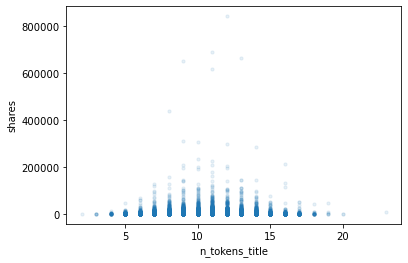

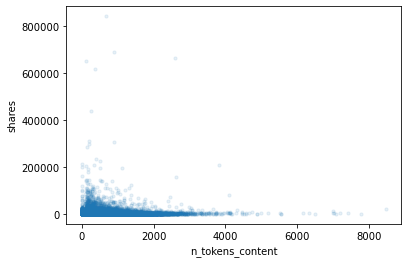

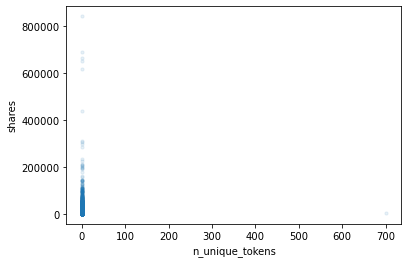

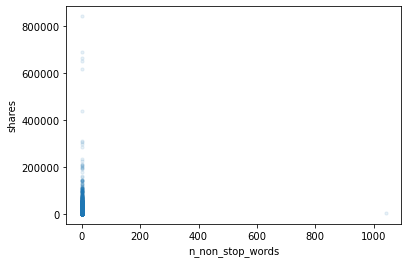

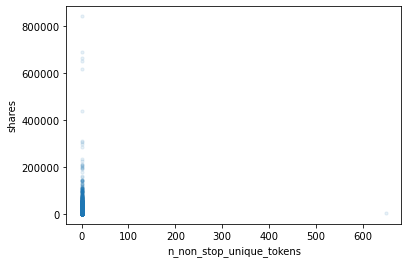

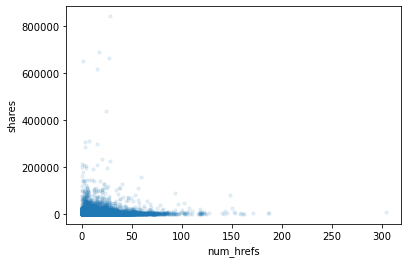

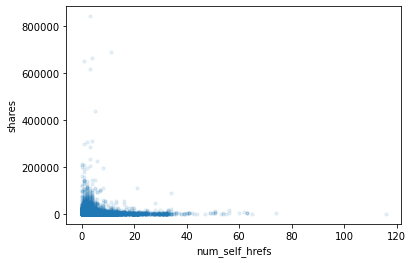

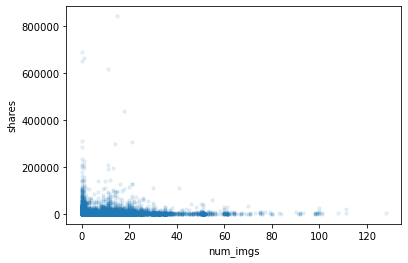

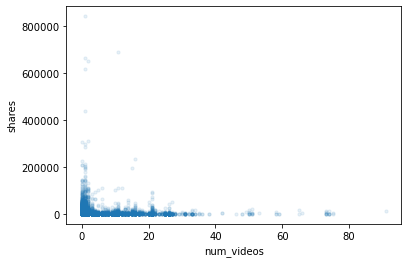

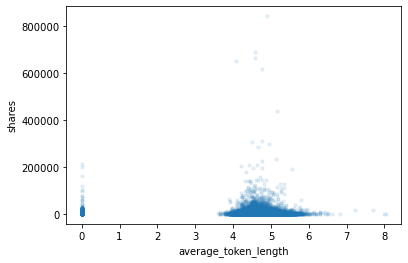

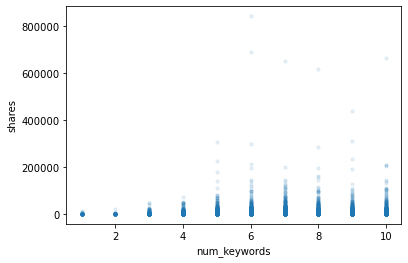

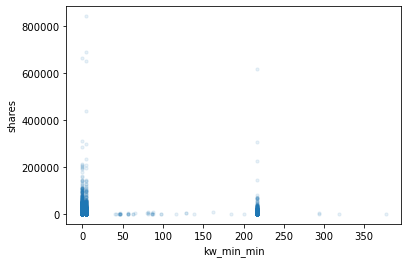

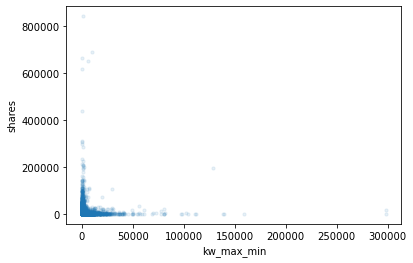

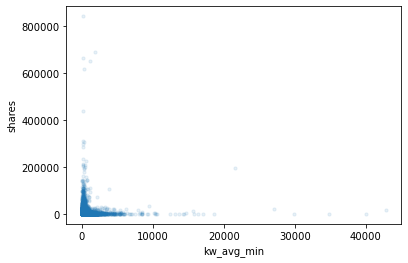

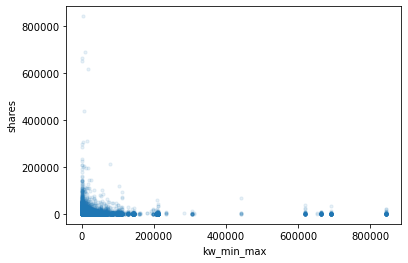

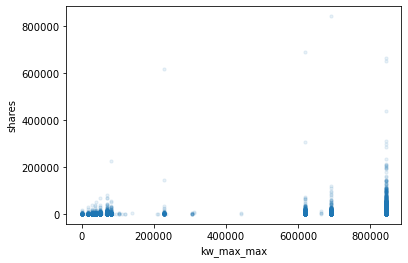

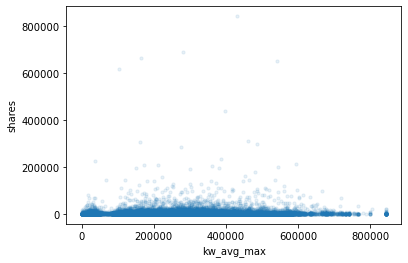

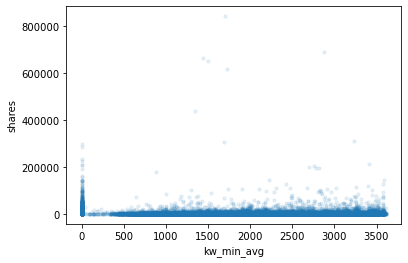

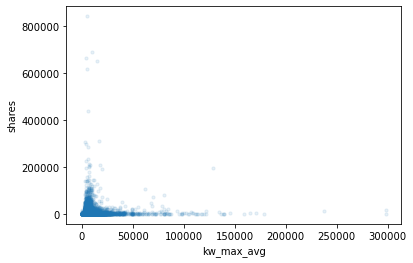

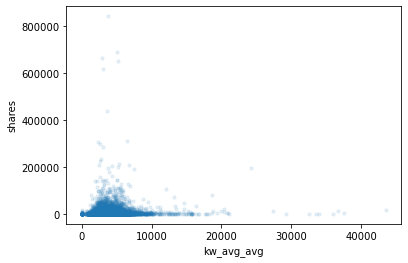

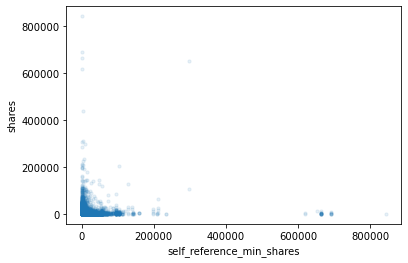

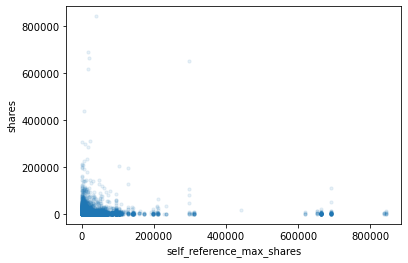

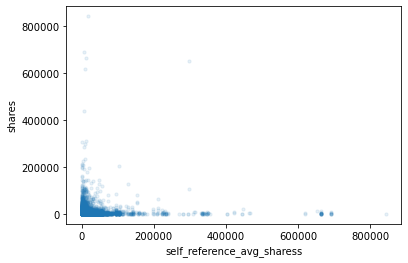

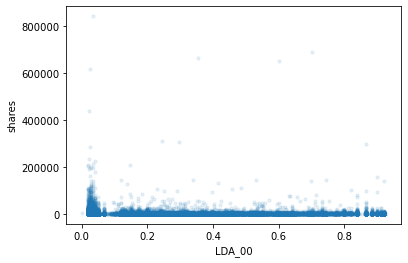

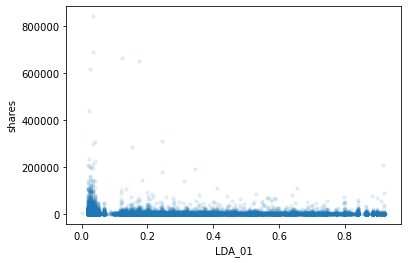

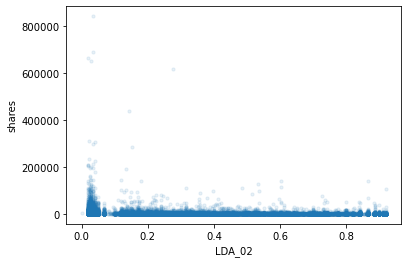

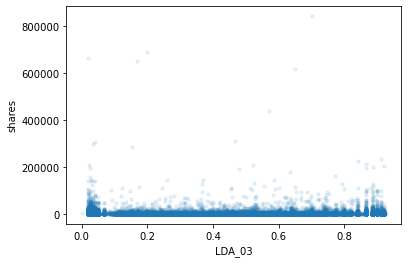

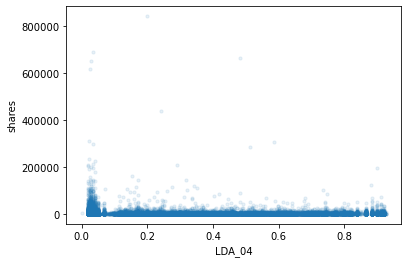

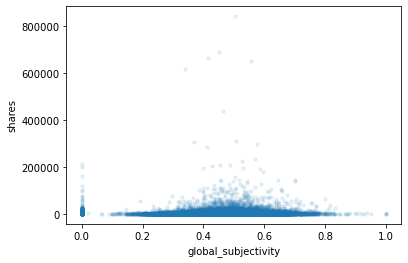

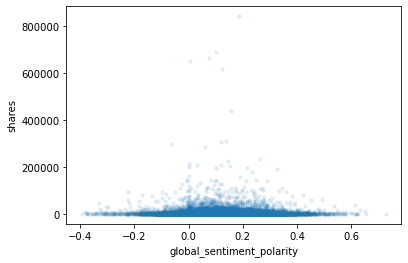

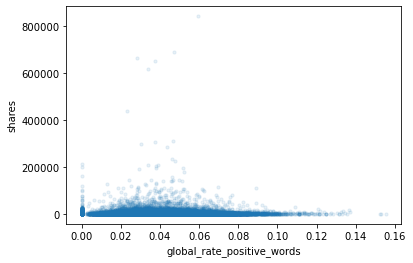

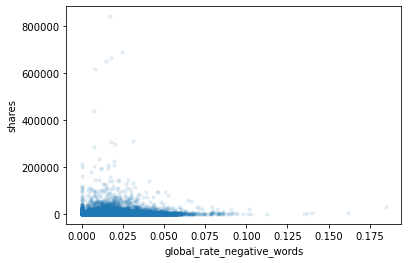

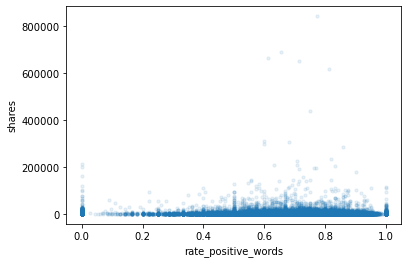

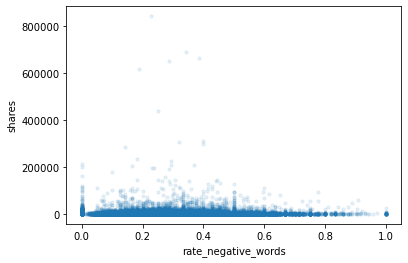

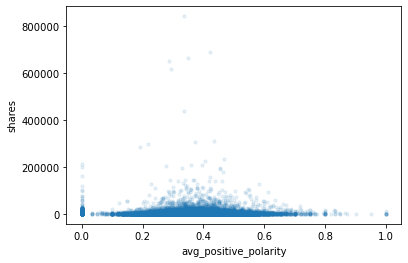

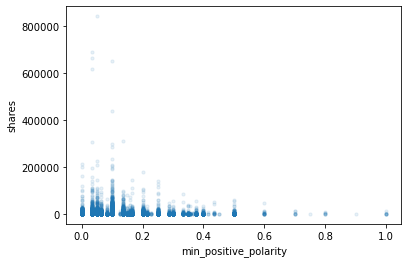

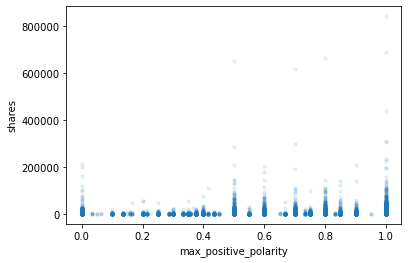

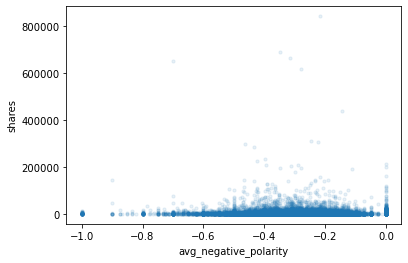

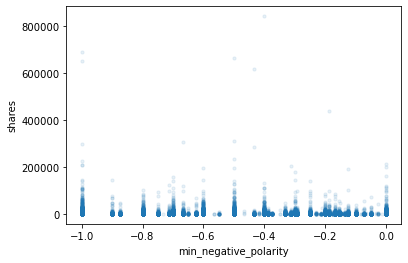

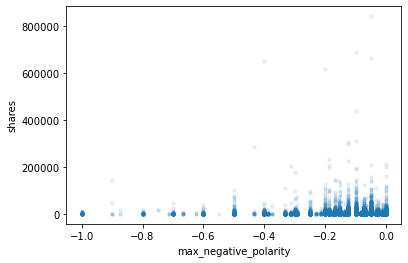

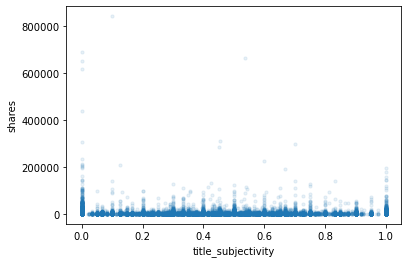

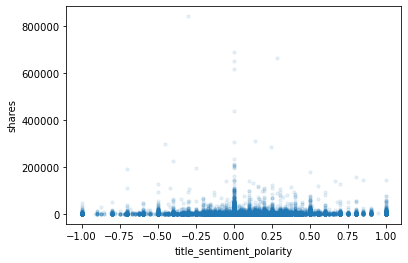

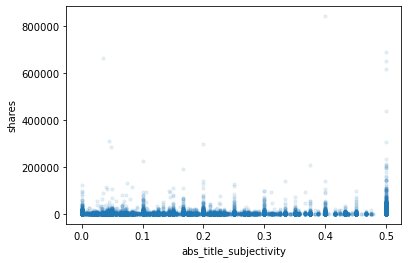

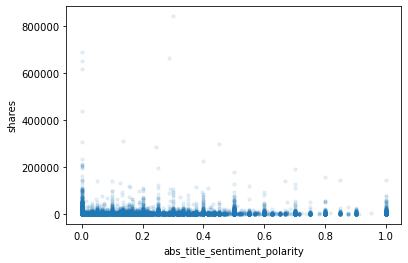

In [5]:
for f in continuous_features:
    df_for_viz.plot.scatter(f, 'shares', s=10, alpha=0.1, colormap="Pastel1")
    plt.show()

#### 1.2 Then, we can view scatter plots of the categorical features vs the target (box plot/violin plot)

In [6]:
def box_plot(df, col):
    df[[col,'shares']].boxplot(by=col)
    plt.ylabel('shares')
    plt.xlabel(col)
    plt.show()

def violin_plot(df, col):
    unique_vals = df[col].dropna().unique()
    dataset = [df[df[col]==val]["shares"].values for val in unique_vals]
    plt.violinplot(dataset = dataset)
    plt.xticks(range(1,len(unique_vals)+1),unique_vals)
    plt.ylabel(col)
    plt.show()


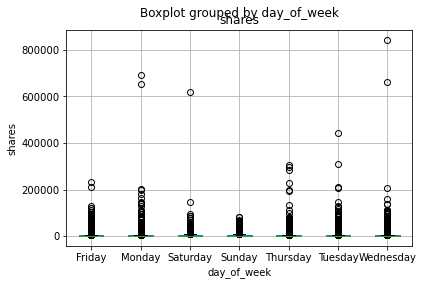

In [7]:
col = 'day_of_week'
columns_my_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_for_viz[[col,'shares']].boxplot(by=col)
plt.ylabel('shares')
plt.xlabel(col)
plt.show()

# TBD: SORT BY DAY OF WEEK

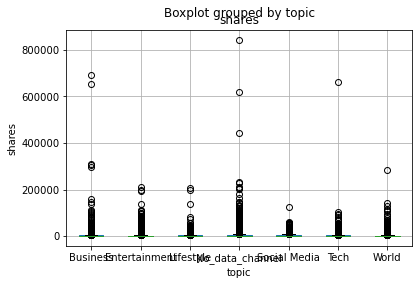

In [8]:
col = 'topic'
df_for_viz[[col,'shares']].boxplot(by=col)
plt.ylabel('shares')
plt.xlabel(col)
plt.show()

### 2. Now, we view the relationships between the features vs the target by viewing the **target as a categorical variable** (whether the article was popular or not)

#### 2.1 We can view scatter plots of the continuous features vs the target (category-specific histograms/box plot/violin plot)

In [9]:
threshold = 1400
df_for_viz['shares_cat'] = df_for_viz['shares'].apply(lambda x: 1 if x > 1400 else 0)
# df_for_viz[['shares', 'shares_cat']].head(20)

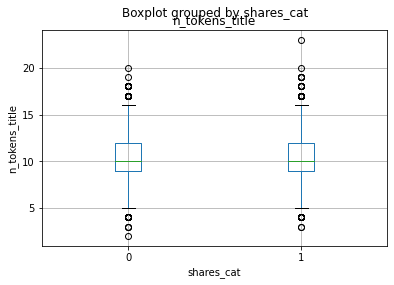

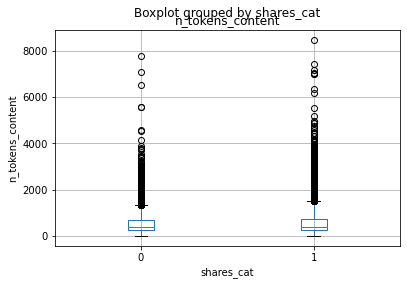

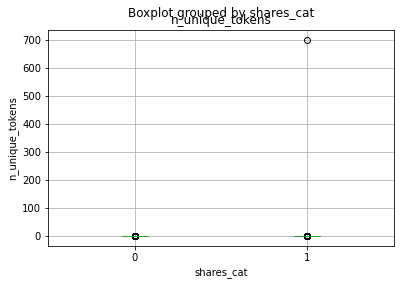

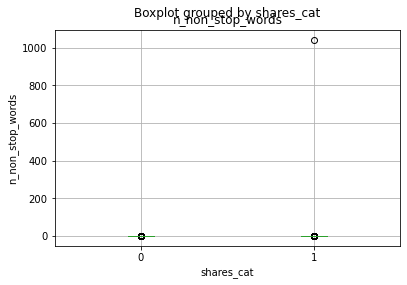

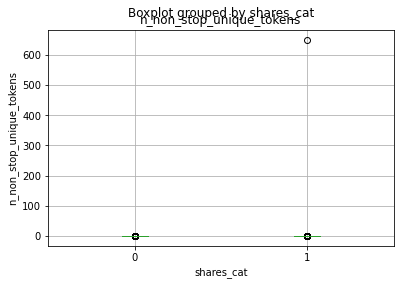

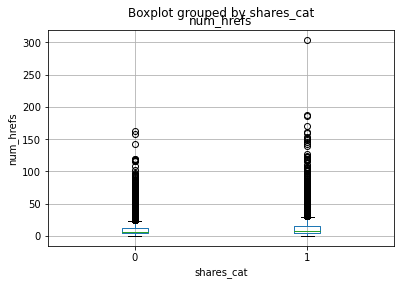

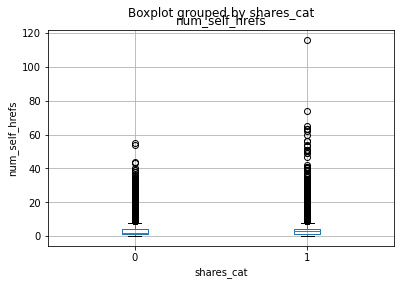

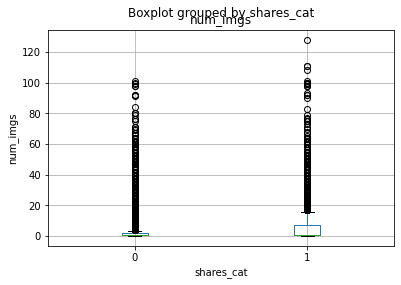

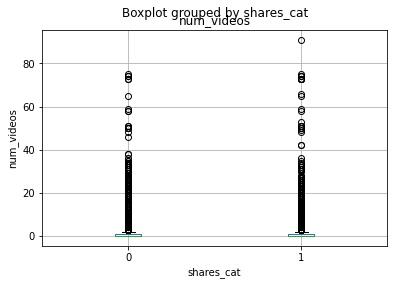

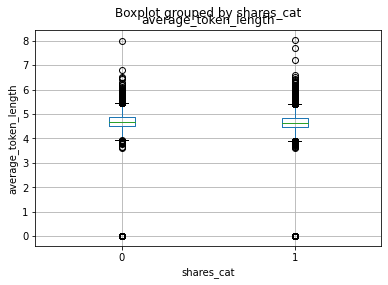

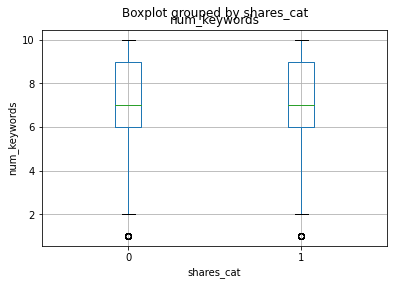

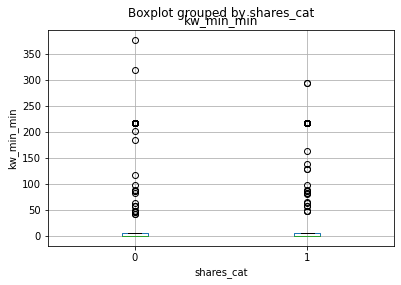

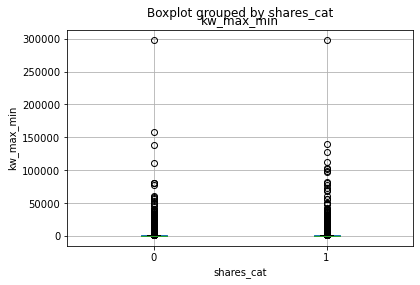

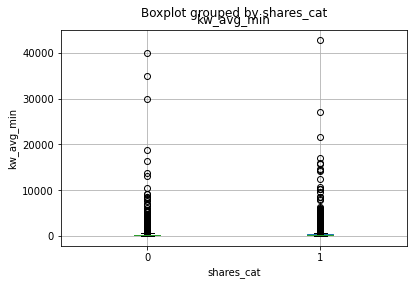

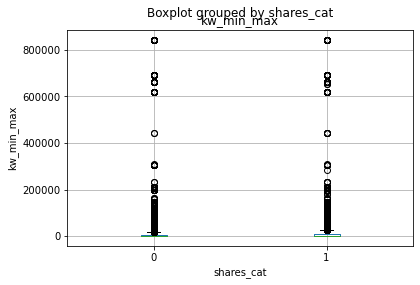

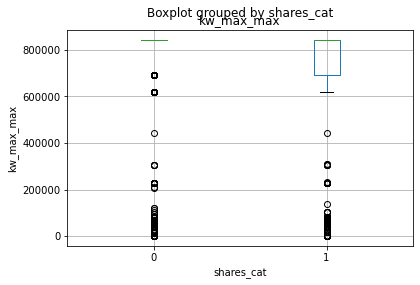

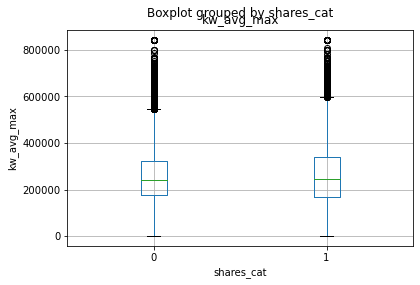

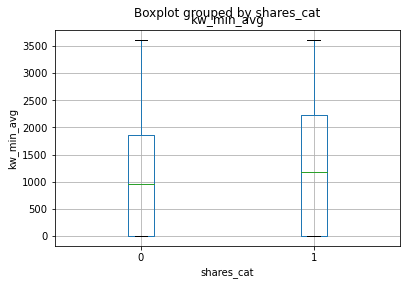

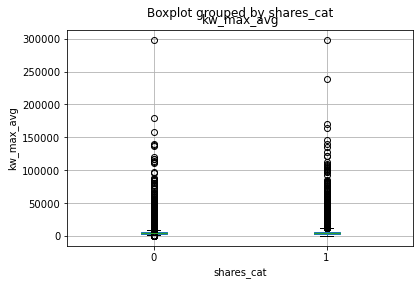

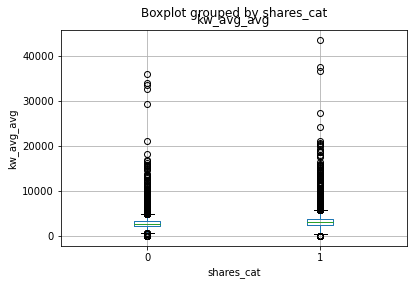

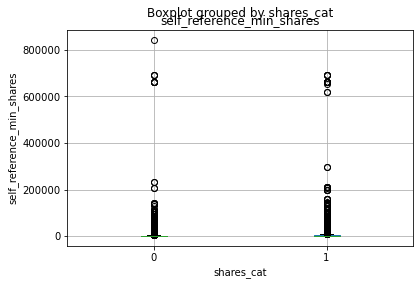

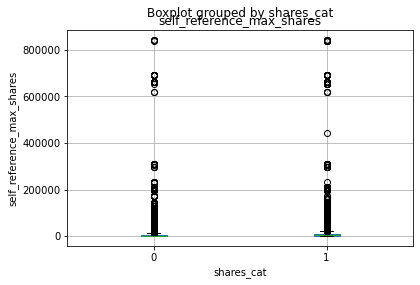

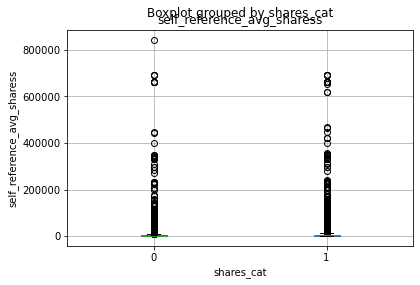

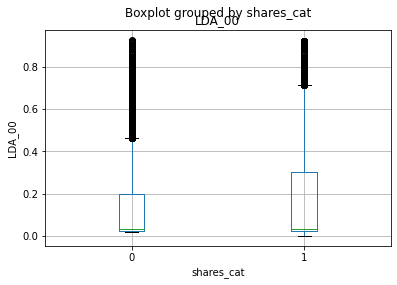

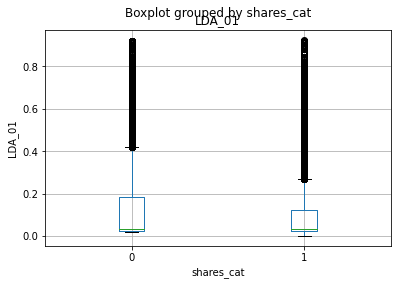

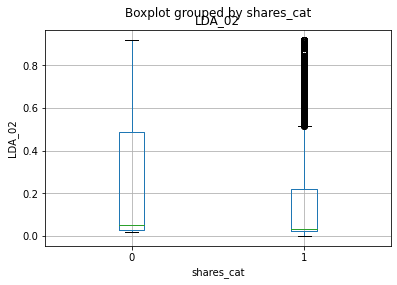

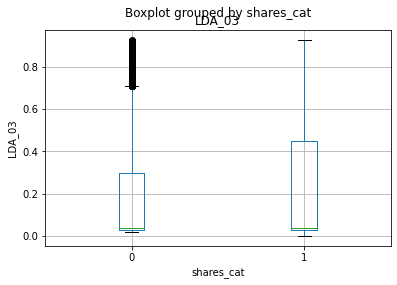

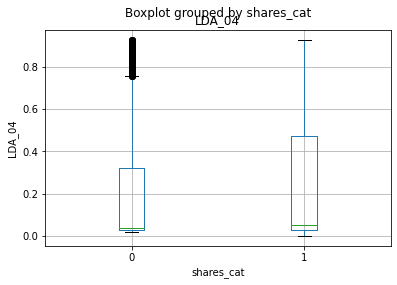

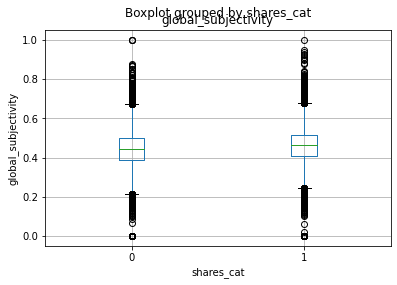

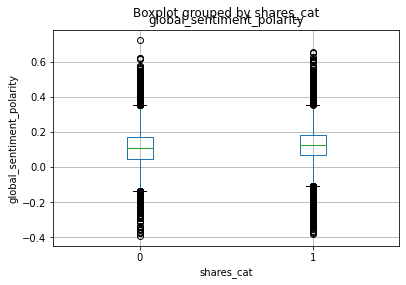

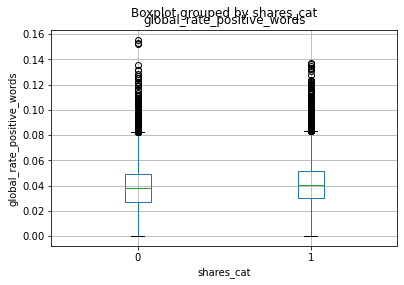

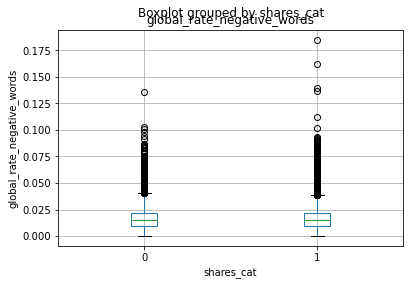

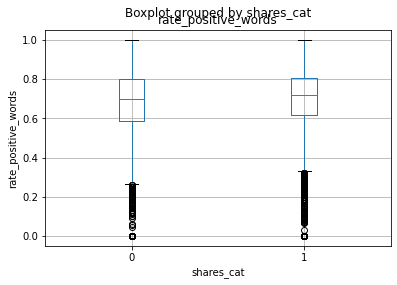

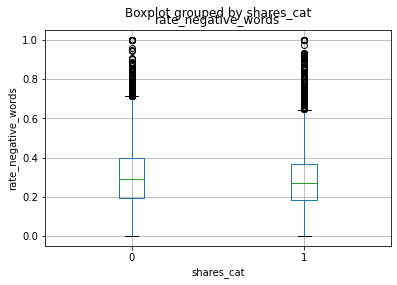

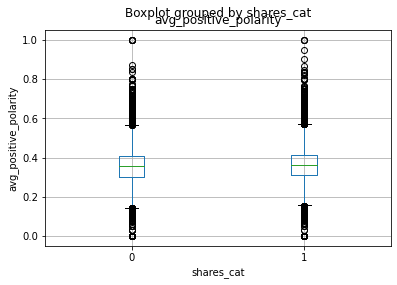

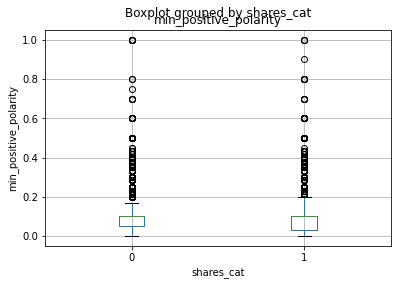

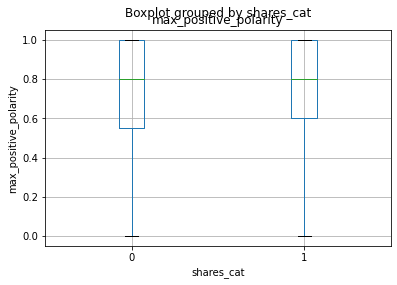

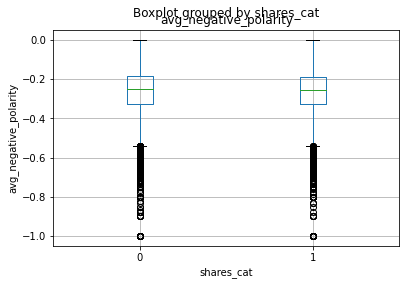

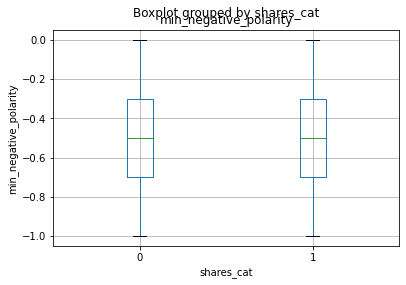

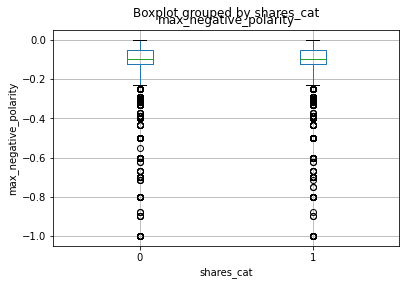

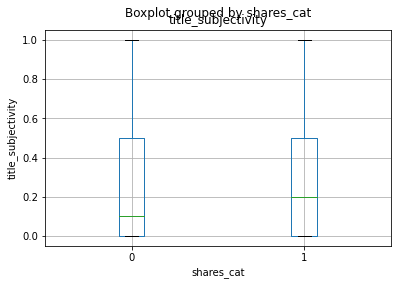

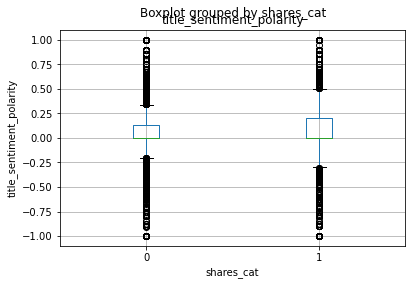

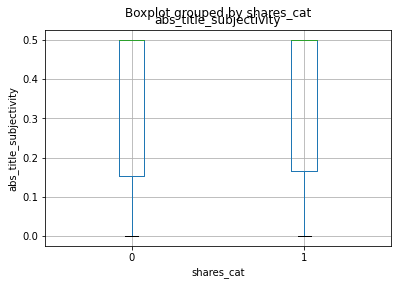

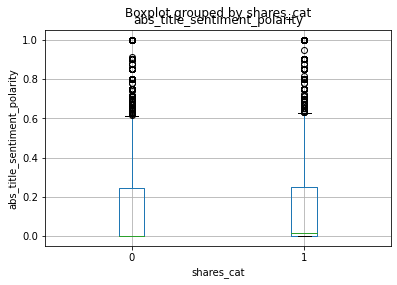

In [10]:
for f in continuous_features:
    df_for_viz[[f,'shares_cat']].boxplot(by='shares_cat')
    plt.ylabel(f)
    plt.xlabel('shares_cat')
    plt.show()

#### 2.2 Finally, we can view scatter plots of the categorical features vs the target (stacked bar plot)

In [11]:
def plot_stacked_bar(df, col):
    count_matrix = df.groupby([col, 'shares_cat']).size().unstack()
    count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
    count_matrix_norm.plot(kind='bar', stacked=True)
    plt.ylabel('Fraction of articles in group')
    # plt.xlabel('Fraction of articles in group')
    plt.legend(loc=4)
    plt.show()


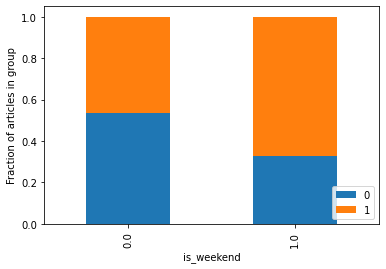

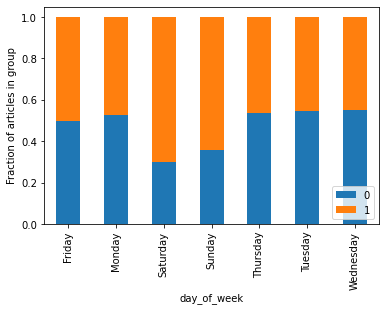

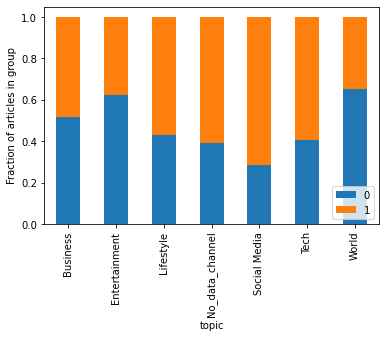

In [12]:
for f in categorical_features:
    plot_stacked_bar(df_for_viz, f)

### Scatter Matrix

In [15]:
df_for_viz.columns


Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'kw_min_min', 'kw_max_min',
       'kw_avg_min', 'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg',
       'kw_max_avg', 'kw_avg_avg', 'self_reference_min_shares',
       'self_reference_max_shares', 'self_reference_avg_sharess', 'is_weekend',
       'LDA_00', 'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_

In [18]:
# cols_for_scatter_mat = ['LDA_02', 
#                         'LDA_04', 
#                         'num_imgs', 
#                         'num_hrefs', 
#                         'kw_min_avg',
#                         'global_rate_negative_words', 
#                         'shares_cat']
cols_for_scatter_mat = ['LDA_02', 
                        'num_imgs', 
                        'kw_min_avg',
                        'num_hrefs', 
                        'shares_cat']
df_for_viz_scatter_mat = df_for_viz[cols_for_scatter_mat]

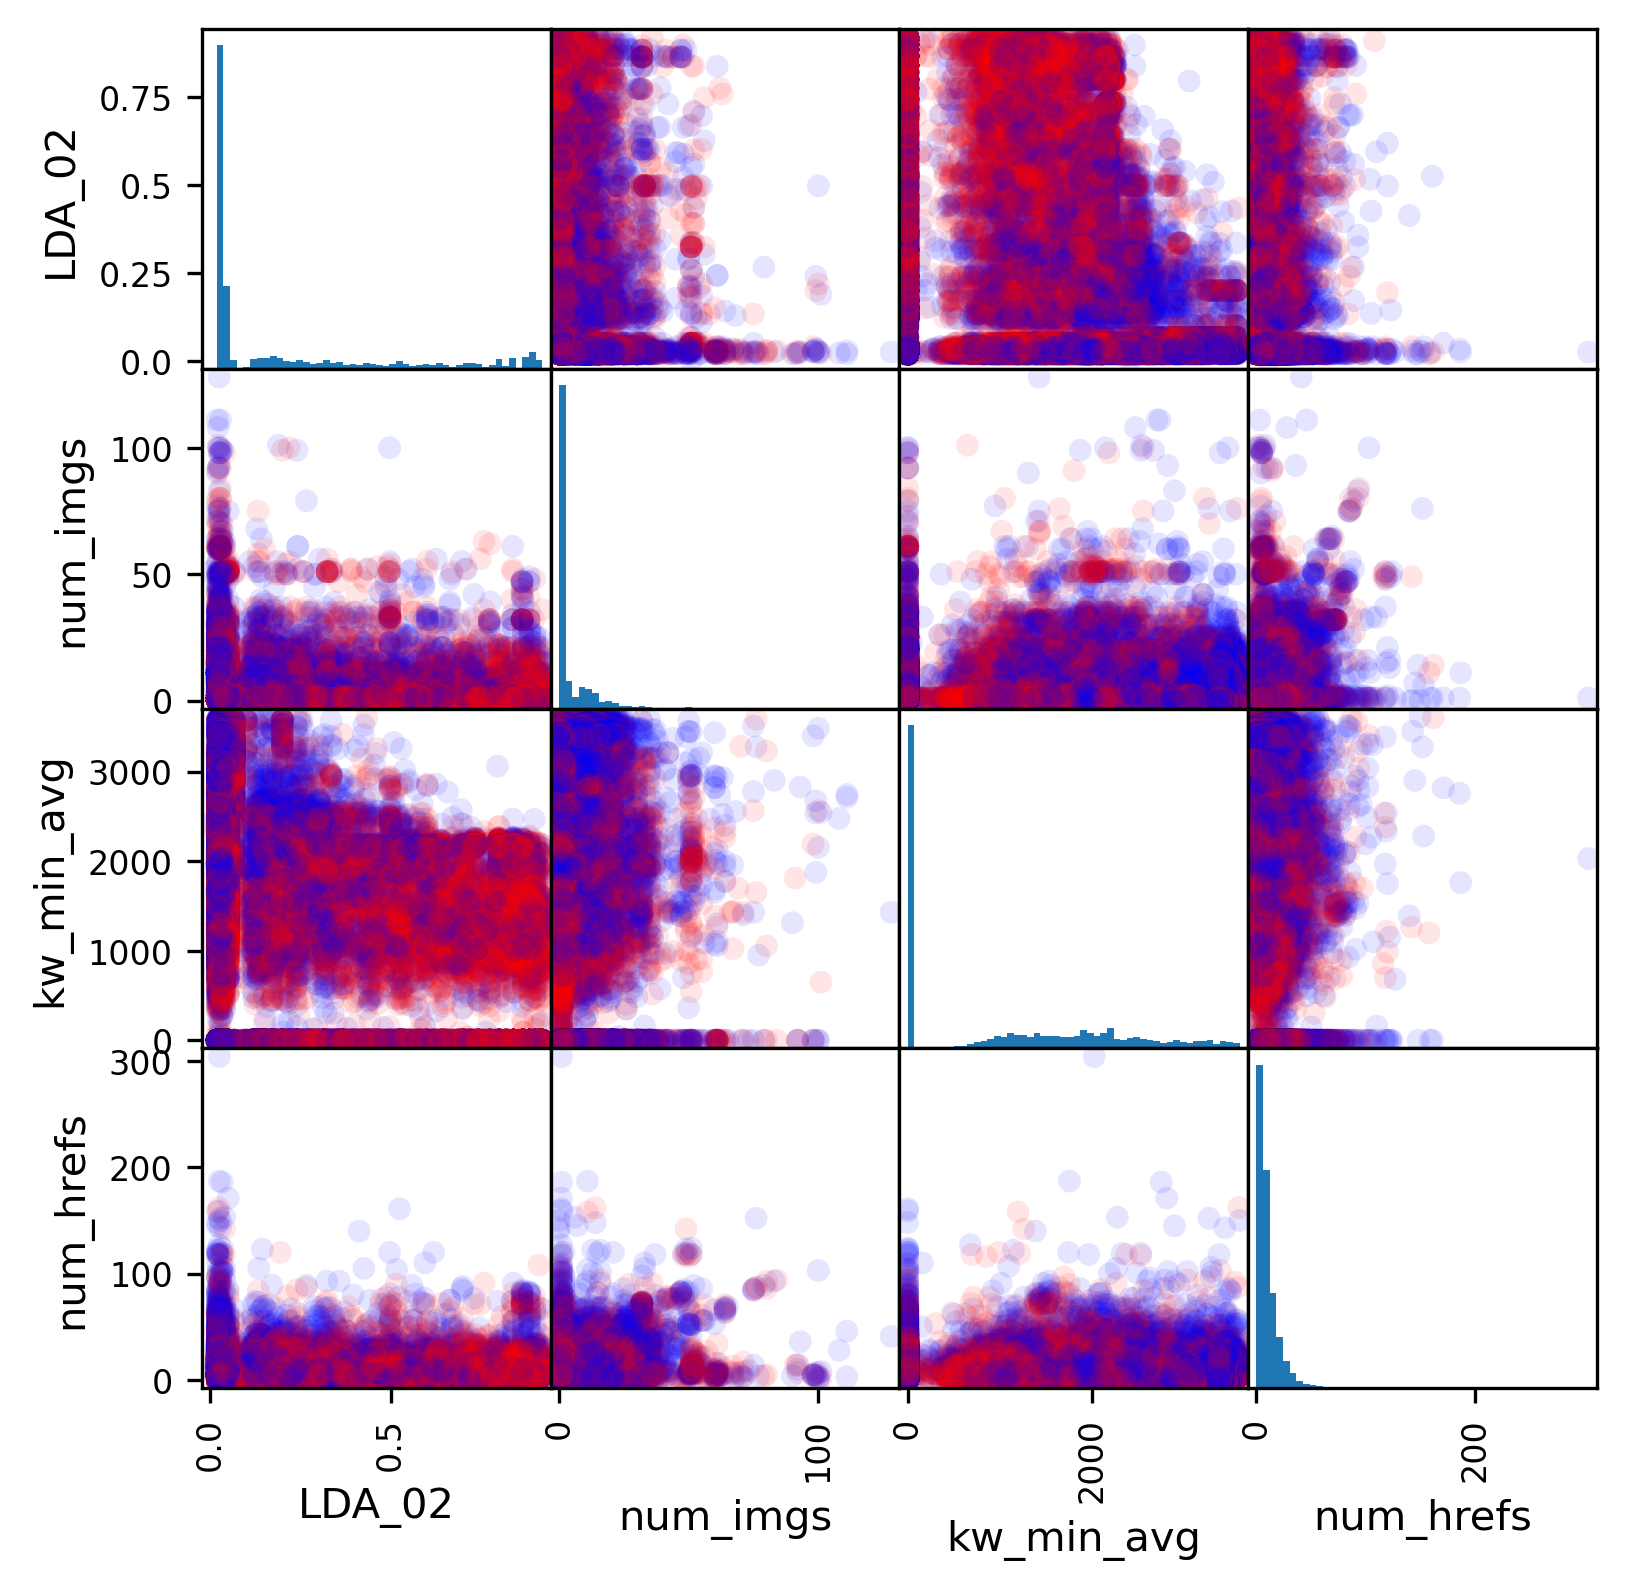

In [25]:
colors = {0:'red', 1:'blue'}
pd.plotting.scatter_matrix(df_for_viz_scatter_mat.select_dtypes(float, int), figsize=(6,6), 
                           c = df_for_viz['shares_cat'].map(colors), 
                           marker='o',hist_kwds={'bins': 50}, s=30, alpha=.1)
# plt.show()
plt.rcParams["figure.dpi"] = 300
# plt.title("Scatter matrix for selected features", x=2.5, y=2.5)
plt.savefig(figures_dir + '3_scatterplot.png')

## Correlation Matrix

In [14]:
print(df_for_viz.shape)
df_for_viz.head()

(39644, 52)


url  timedelta  \
0  http://mashable.com/2013/01/07/amazon-instant-...      731.0   
1  http://mashable.com/2013/01/07/ap-samsung-spon...      731.0   
2  http://mashable.com/2013/01/07/apple-40-billio...      731.0   
3  http://mashable.com/2013/01/07/astronaut-notre...      731.0   
4   http://mashable.com/2013/01/07/att-u-verse-apps/      731.0   

   n_tokens_title  n_tokens_content  n_unique_tokens  n_non_stop_words  \
0            12.0             219.0         0.663594               1.0   
1             9.0             255.0         0.604743               1.0   
2             9.0             211.0         0.575130               1.0   
3             9.0             531.0         0.503788               1.0   
4            13.0            1072.0         0.415646               1.0   

   n_non_stop_unique_tokens  num_hrefs  num_self_hrefs  num_imgs  ...  \
0                  0.815385        4.0             2.0       1.0  ...   
1                  0.791946        3.0             1.0       1.0  ...   
2                  0.663866        3.0             1.0       1.0  ...   
3                  0.665635        9.0             0.0       1.0  ...   
4                  0.540890       19.0            19.0      20.0  ...   

   max_negative_polarity  title_subjectivity  title_sentiment_polarity  \
0              -0.200000            0.500000                 -0.187500   
1              -0.100000            0.000000                  0.000000   
2              -0.133333            0.000000                  0.000000   
3              -0.166667            0.000000                  0.000000   
4              -0.050000            0.454545                  0.136364   

   abs_title_subjectivity  abs_title_sentiment_polarity  shares  day_of_week  \
0                0.000000                      0.187500     593       Monday   
1                0.500000                      0.000000     711       Monday   
2                0.500000                      0.000000    1500       Monday   
3                0.500000                      0.000000    1200       Monday   
4                0.045455                      0.136364     505       Monday   

           topic  popular  shares_cat  
0  Entertainment        0           0  
1       Business        0           0  
2       Business        1           1  
3  Entertainment        0           0  
4           Tech        0           0  

[5 rows x 52 columns]

/tmp/ipykernel_1737077/1689252610.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(figures_dir + 'correlation_matrix.png', bbox_inches='tight')


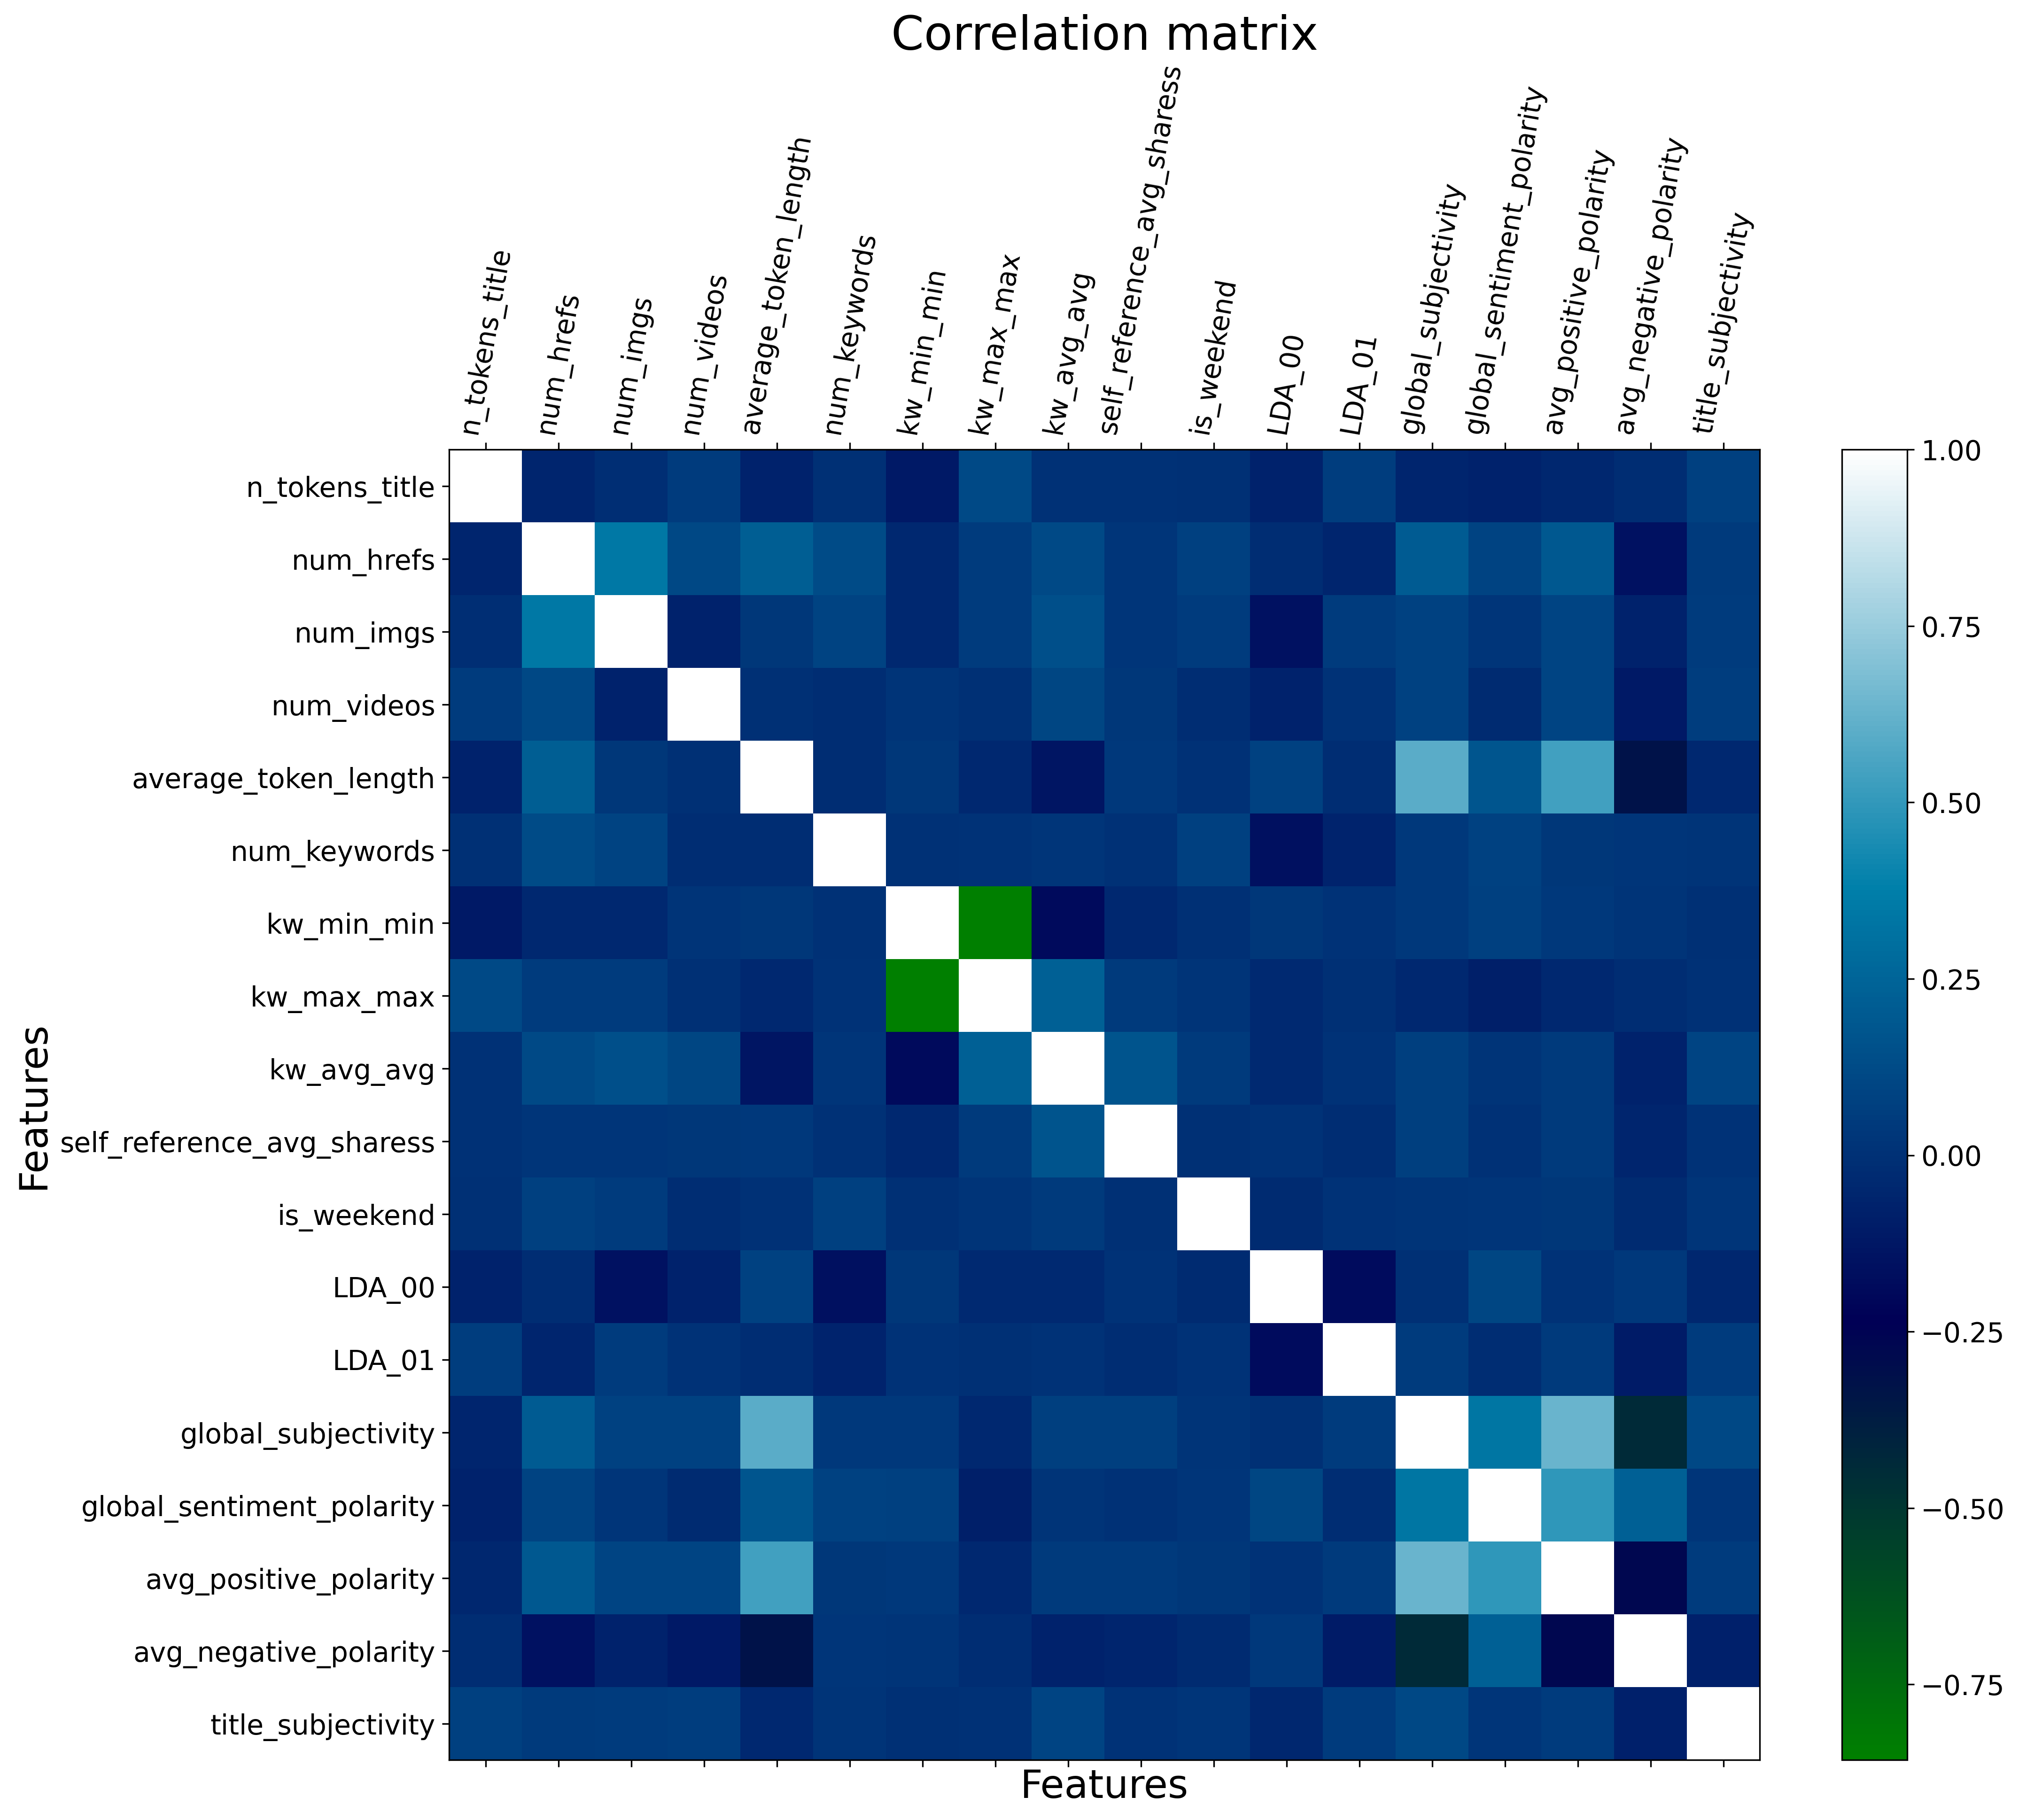

In [38]:
cols_to_keep_for_corr = ['n_tokens_title', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'kw_min_min',
       'kw_max_max', 'kw_avg_avg', 'self_reference_avg_sharess', 'is_weekend',
       'LDA_00', 'LDA_01', 'global_subjectivity',
       'global_sentiment_polarity', 'avg_positive_polarity', 'avg_negative_polarity',
       'title_subjectivity', ]

# df_corr = df_for_viz.select_dtypes(['number']).drop(labels=, axis=1).copy()
df_corr = df_for_viz.select_dtypes(['number'])[cols_to_keep_for_corr].copy()

f = plt.figure(figsize=(15, 12))
corr_mat = df_corr.corr()
plt.matshow(corr_mat, fignum=f.number, cmap="ocean")
plt.xticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, 
           fontsize=14, rotation=80)
plt.yticks(range(df_corr.select_dtypes(['number']).shape[1]), df_corr.select_dtypes(['number']).columns, 
           fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

plt.xlabel("Features", fontsize=20)
plt.ylabel("Features", fontsize=20)
plt.title("Correlation matrix", fontsize=24)
plt.rcParams["figure.dpi"] = 300
# plt.rcParams["figure.autolayout"] = True
# plt.tight_layout()
plt.savefig(figures_dir + 'correlation_matrix.png', bbox_inches='tight')

### Popularity of different topics over time

In [28]:
timeline_cols = ['timedelta', 'topic', 'shares']
df_2 = df_for_viz[timeline_cols]
df_2 = df_2.sort_values(by=['timedelta', 'topic'], ascending=[False, True]).reset_index(drop=True)
df_2['week'] = df_2['timedelta'].apply(lambda x: 105 - x//7)
df_2.head()

timedelta     topic  shares  week
0      731.0  Business     711   1.0
1      731.0  Business    1500   1.0
2      731.0  Business    3100   1.0
3      731.0  Business     852   1.0
4      731.0  Business     425   1.0

In [29]:
timeline_cols = ['timedelta', 'topic', 'shares']
df_2 = df_for_viz[timeline_cols]
df_2 = df_2.sort_values(by=['timedelta', 'topic'], ascending=[False, True]).reset_index(drop=True)
df_2['month'] = df_2['timedelta'].apply(lambda x: 25 - x//30)

In [30]:
import datetime
import calendar
def get_month(x):
    if x >= 25:
        m = x - 24
        y = 2
    elif x >= 13:
        m = x - 12
        y = 1
    else:
        m = x
        y = 0
    month = datetime.date(year=2013 + y, month=int(m), day=calendar.monthrange(2013 + y, int(m))[1])
    return month

In [32]:
grouped_topic_week = df_2[['topic', 'month', 'shares']].groupby(['month', 'topic']).sum()
grouped_topic_week = grouped_topic_week.reset_index()
grouped_topic_week['mth'] = grouped_topic_week['month'].apply(lambda x: get_month(x))
grouped_topic_week = grouped_topic_week.pivot(index='mth', columns='topic', values='shares')
grouped_topic_week = grouped_topic_week.drop('No_data_channel', axis=1)

In [33]:
grouped_topic_week.head()

topic       Business  Entertainment  Lifestyle  Social Media     Tech   World
mth                                                                          
2013-01-31    160459         299054     226556        229032   397951  207939
2013-02-28    663975         693077     391783        518750   969506  470171
2013-03-31   1004790         563767     399720        601251  1560330  471218
2013-04-30   1623899         889908     374223        486288  1047710  600122
2013-05-31    683842         657153     364950        346246   908749  422963

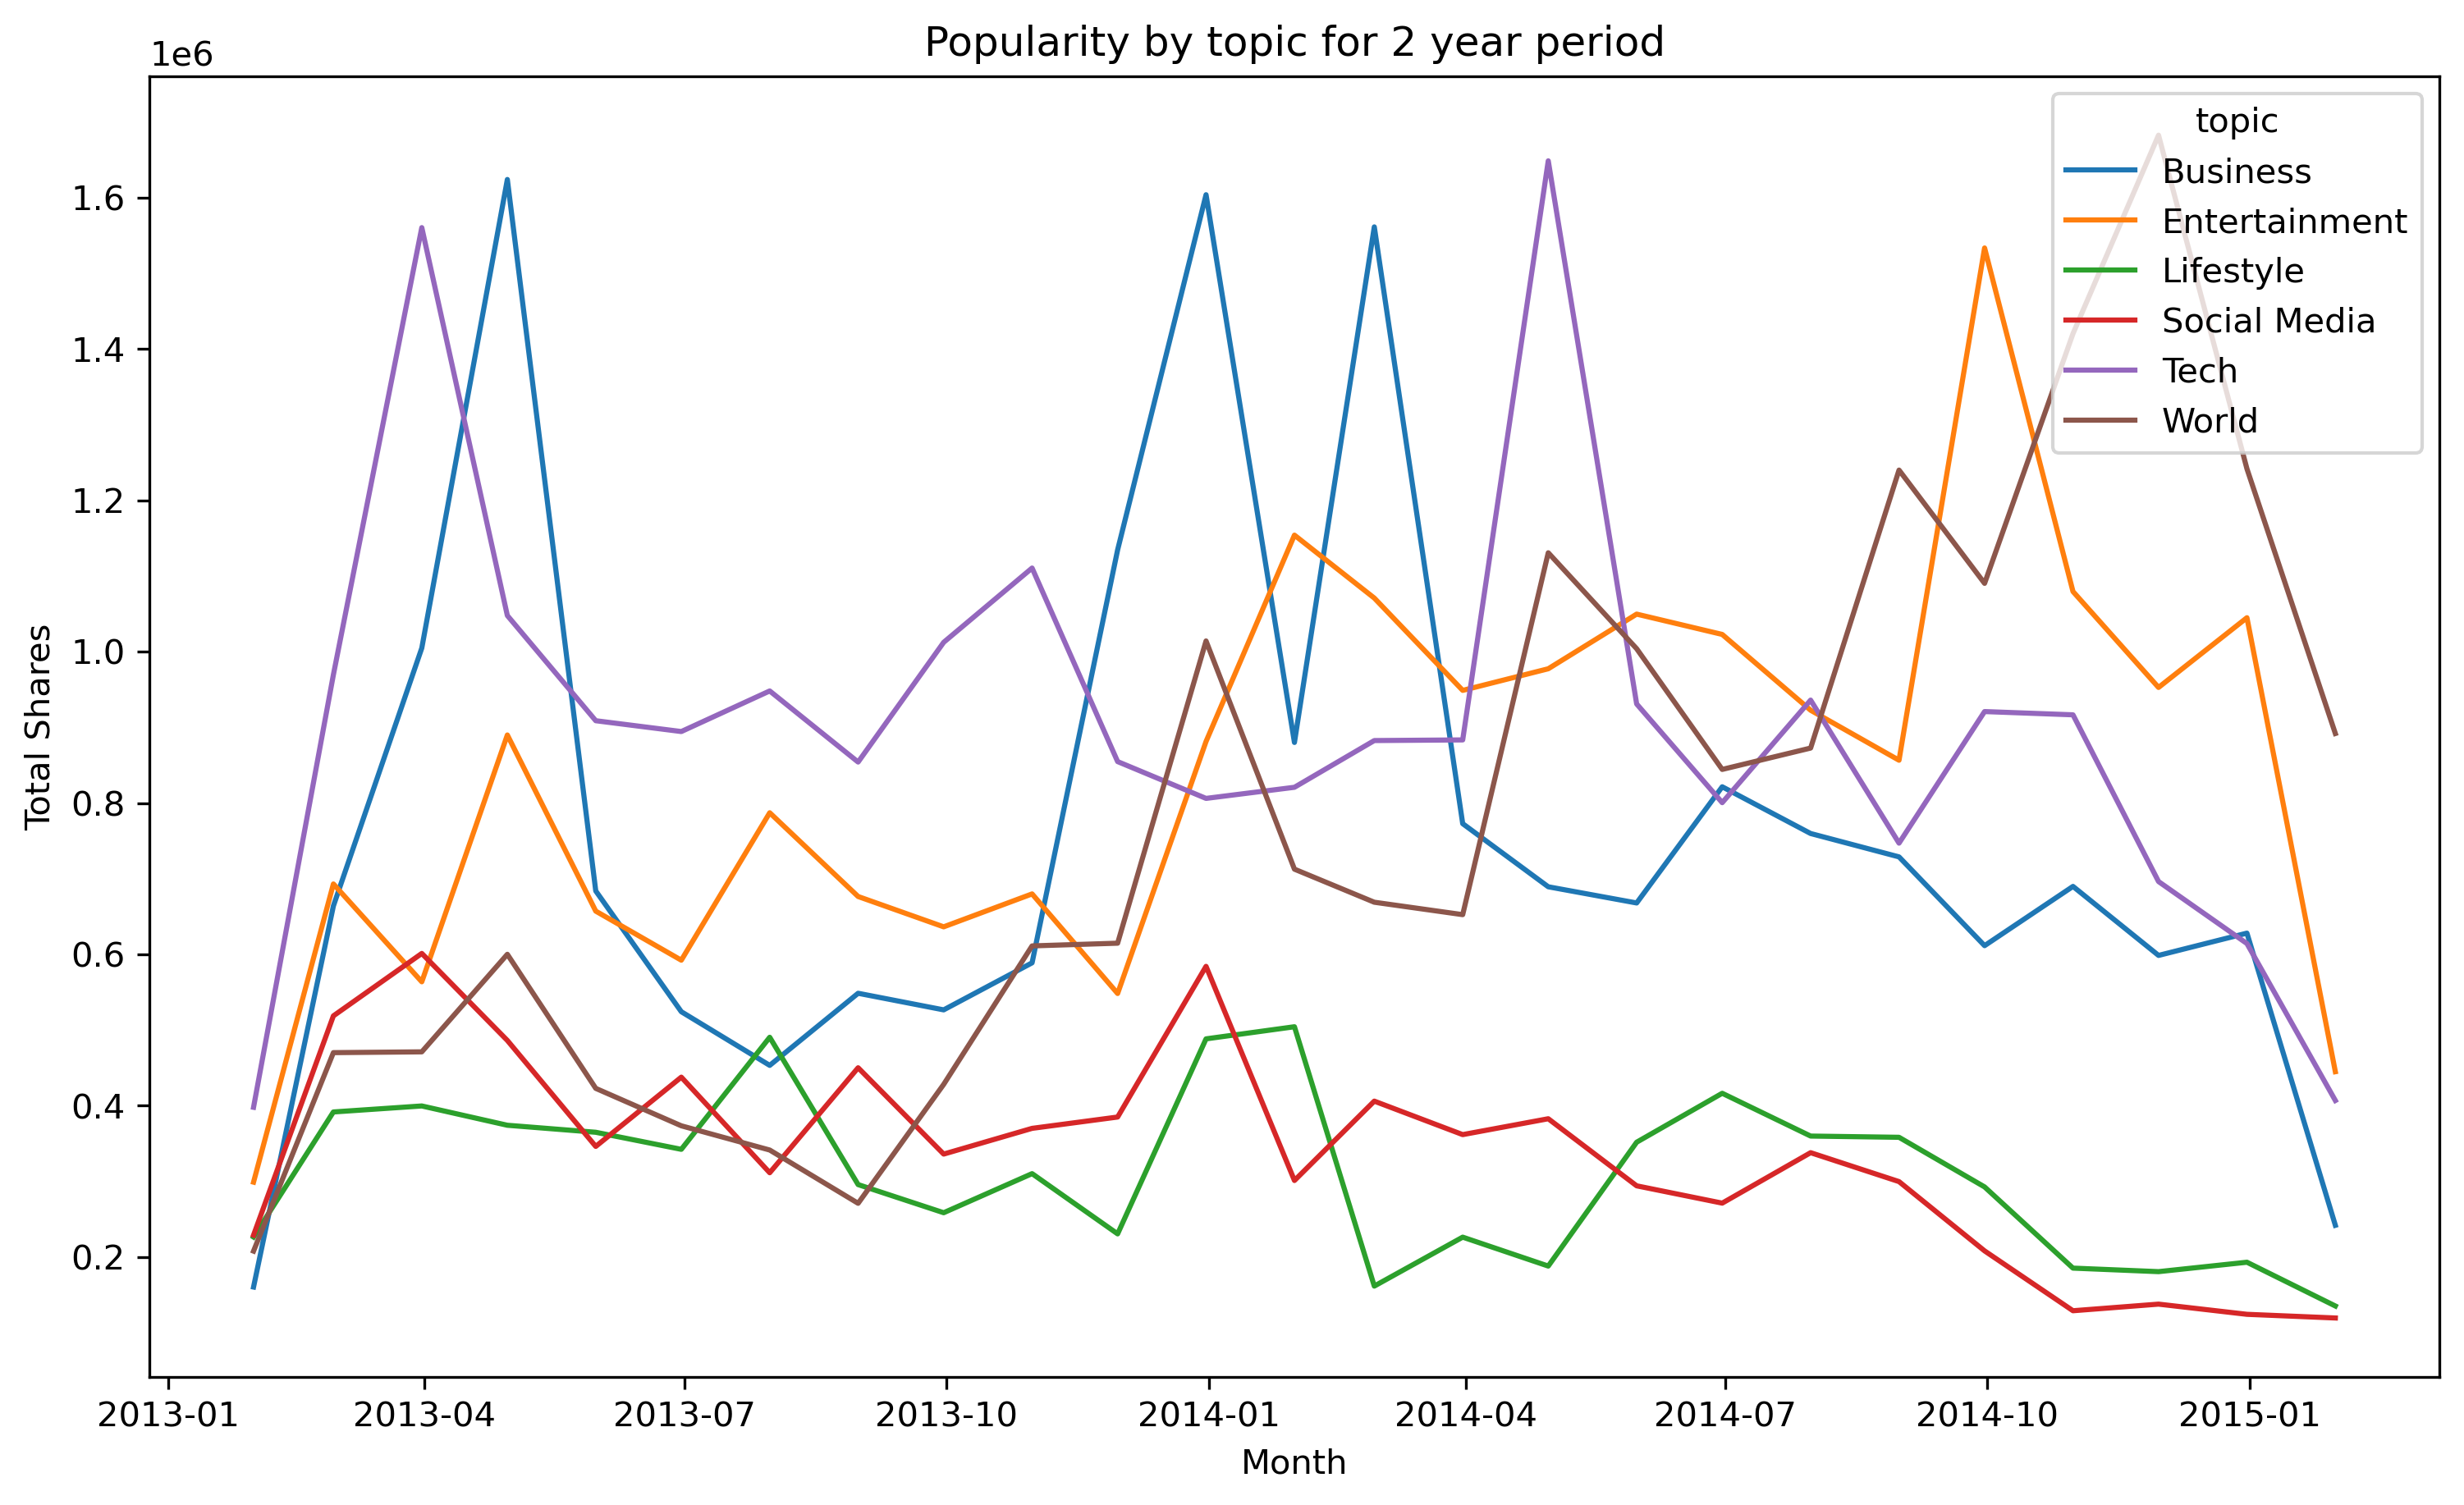

In [34]:
grouped_topic_week.plot.line(figsize=(12,7))
plt.xlabel("Month")
plt.ylabel("Total Shares")
plt.title("Popularity by topic for 2 year period")
plt.rcParams["figure.dpi"] = 300
plt.savefig(figures_dir + '1_popularity_by_topic_timeline.png')